In [1]:
import numpy as np
import astropy.units as u
import astropy.wcs.utils as utils
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from scipy import constants
from scipy.ndimage import shift
from astropy.modeling import models, fitting

In [2]:
epoch_1_path = ""
epoch_2_path = ""

In [3]:
epoch_1 = fits.open((epoch_1_path + '.fits'))[0]
epoch_2 = fits.open((epoch_2_path + '.fits'))[0]

In [4]:
#if defing position from a central source set to true
central_position_refrence = True
#defines the position of the star in degrees
#define in hours : minutes : seconds
RA_star = 15 * (5. + (42./60) + 27.677/3600)
DEC_star = -1 * (1. + 20./60 + 1.33/3600)
center_star = SkyCoord(ra = RA_star, dec = DEC_star, unit = 'deg')

In [5]:
#defines a cutout based on the position of the star
cutout_size = (.06 * u.deg, .06 * u.deg)
cutout_1 = Cutout2D(epoch_1.data, center_star, cutout_size, wcs=WCS(epoch_1.header))
cutout_2 = Cutout2D(epoch_2.data, center_star, cutout_size, wcs=WCS(epoch_2.header))
#the distance to the star in parsecs
distance_star = 414.3
#the ammount of time between the images in years
time_between_epochs = 13

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [6]:
#this creates the single source gaussian system that will be used to find the position of the knots
#the function asks for the image used, the x coord of the emission, the y coord of the emission, the size of the refrence used, the ampltude of the image, 
#the predicted x coord of the cebter if the gaussian in the refrence box, and the predicted y coord of the cebter if the gaussian in the refrence box
def single_source_gaussian(image,x_coord,y_coord,size,amp,center_x,center_y):
        #sub defines the base image minius the median of the image
        sub = image[y_coord-size:y_coord+size, x_coord-size:x_coord+size] - np.median(image[y_coord-size:y_coord+size, x_coord-size:x_coord+size])
        #median is used to subtract not from the base image
        median = np.median(image[y_coord-size:y_coord+size, x_coord-size:x_coord+size])
        #this establishes the size of the plot 
        y, x = np.mgrid[0:2*size, 0:2*size]
        #this establishes the inital guess for the knot position and assumes a 2 dimentional gaussian shape
        p_init_gauss1 = models.Gaussian2D(amp, center_x, center_y)
        p_init = p_init_gauss1 
        #this uses the Levenberg–Marquardt least squares which uses a nonlinear regresssion to find the center of the knot
        fit_p1 = fitting.LevMarLSQFitter(calc_uncertainties=True)
        #this then uses the initial guess and applies the LevMarLSQ fitter
        p1 = fit_p1(p_init, x, y, sub, weights=None)
        #this plots the initial unmdified cutout
        plt.subplots(1,3, figsize=(18,5))
        plt.subplot(131)
        plt.imshow(sub, vmin=-10,vmax=np.max(sub), origin="lower")
        plt.scatter(p1.x_mean.value,p1.y_mean.value, marker='.', s=40, color='red')
        plt.colorbar()
        plt.title('data')
        #this then displays just the model without the background 
        plt.subplot(132)
        plt.imshow(p1(x,y), origin="lower")
        plt.scatter(p1.x_mean.value,p1.y_mean.value, marker='.', s=40, color='red')
        plt.colorbar()
        plt.title('model')
        #this subtracts the model from the inital cutout displaing how well the model is
        plt.subplot(133)
        plt.imshow(image[y_coord-size:y_coord+size, x_coord-size:x_coord+size] - p1(x,y) - median, vmin=np.min(sub),vmax=np.max(sub), origin="lower")
        plt.scatter(p1.x_mean.value,p1.y_mean.value, marker='.', s=40, color='red')
        plt.colorbar()
        plt.title('residual')
        #this then returns the model
        return p1

In [7]:
#creates matrices that store values in
#position of the emision relative to the center position - this is not used if "central_position_refrence" is false
position = []
#this stores the velocity of the emission
velocity = []
#the x coordnate of the first epoch emission in the first epoch cutout coordnate system
x_coord_emission_1 = []
#the y coordnate of the first epoch emission in the first epoch cutout coordnate system
y_coord_emission_1 = []
#the x coordnate of the second epoch emission in the first epoch cutout coordnate system
x_coord_emission_2 = []
#the y coordnate of the second epoch emission in the first epoch cutout coordnate system
y_coord_emission_2 = []
#seperation between the first emission and second emission
emission_separation  = []
#x component of velocity
x_velocity = []
#y component of velocity  
y_velocity = []

Knot 1
velocity (km s-1) 167.27123834958837
angle (radians) 0.760610328282191
x velocity (km s-1) 121.1738622960488
y velocity (km s-1) 115.31072055651637
Knot 2
velocity (km s-1) 211.2473999527833
angle (radians) 0.6699440544742434
x velocity (km s-1) 165.5876277126467
y velocity (km s-1) 131.17241148697806
Knot 3
velocity (km s-1) 212.93761601920278
angle (radians) 0.8158649364757888
x velocity (km s-1) 145.91309530270294
y velocity (km s-1) 155.08641763586445
Knot 4
velocity (km s-1) 216.5054345190205
angle (radians) 0.7993412200986438
x velocity (km s-1) 150.94307218984414
y velocity (km s-1) 155.2120875903722
Knot 5
velocity (km s-1) 248.22802669638926
angle (radians) 0.7638645476117376
x velocity (km s-1) 179.26239592550274
y velocity (km s-1) 171.70365938043264
Knot 6
velocity (km s-1) 88.40205177968788
angle (radians) 0.8169304000972919
x velocity (km s-1) 60.507872997555495
y velocity (km s-1) 64.44936046362533
Knot 7
velocity (km s-1) 258.58013378312404
angle (radians) 0.7957

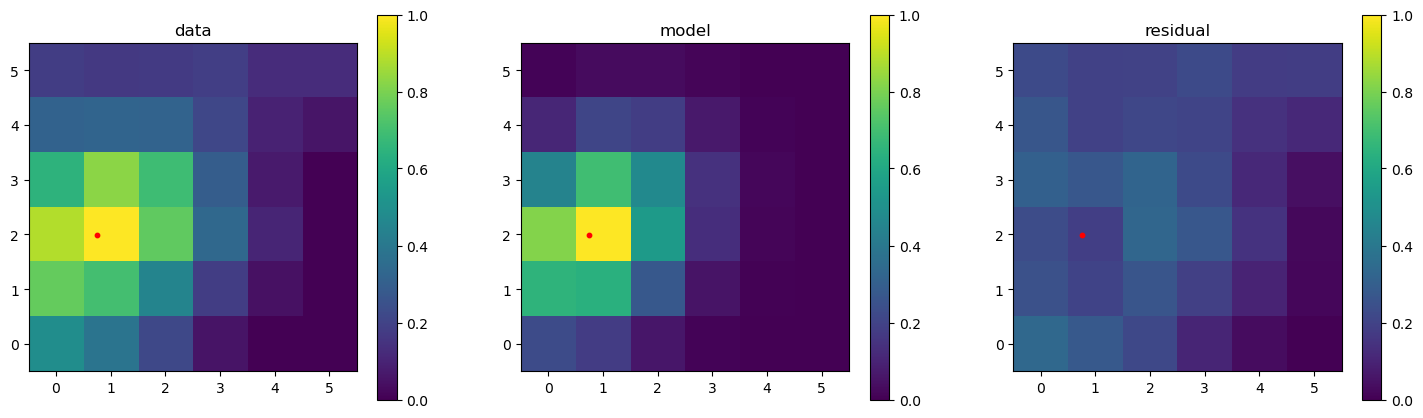

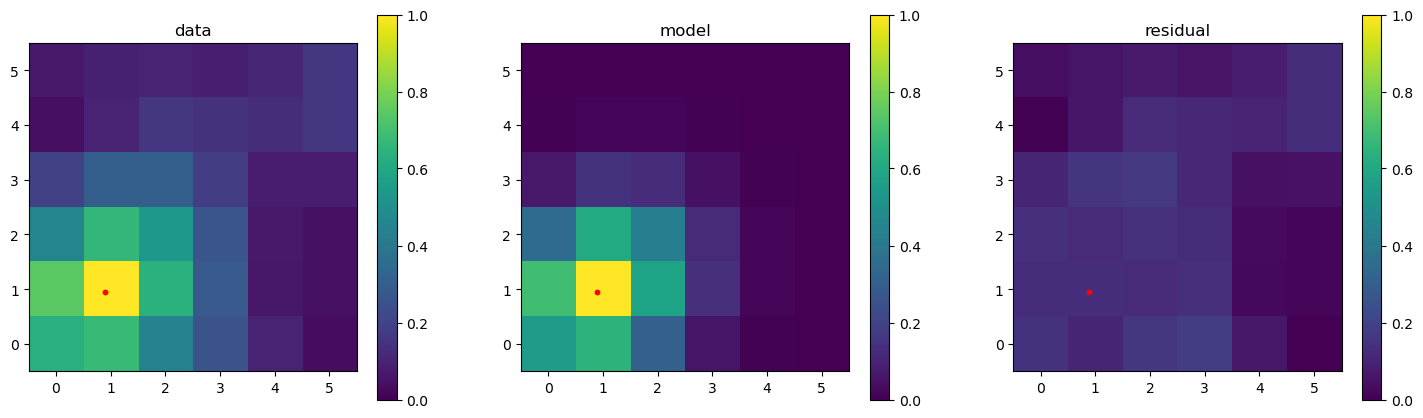

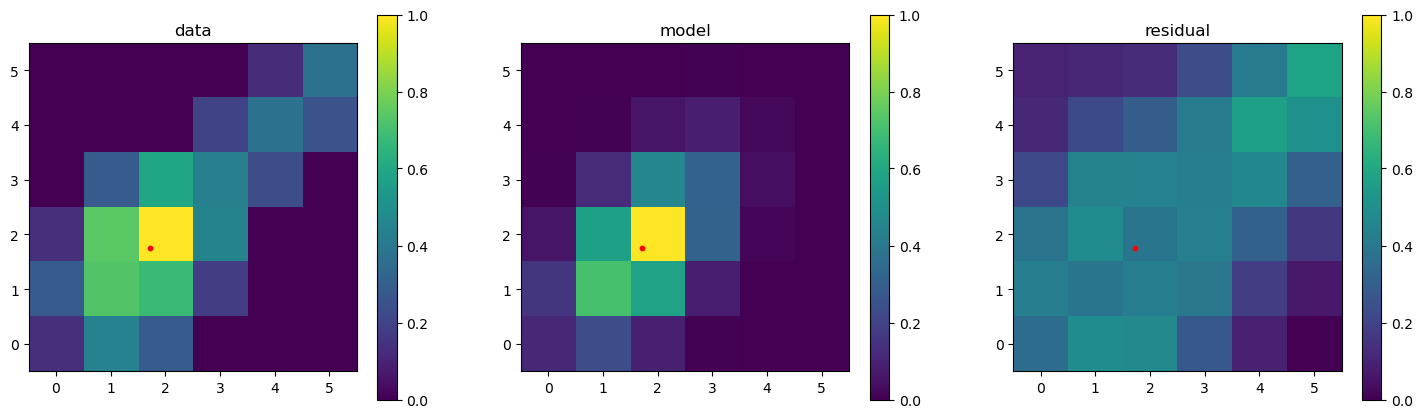

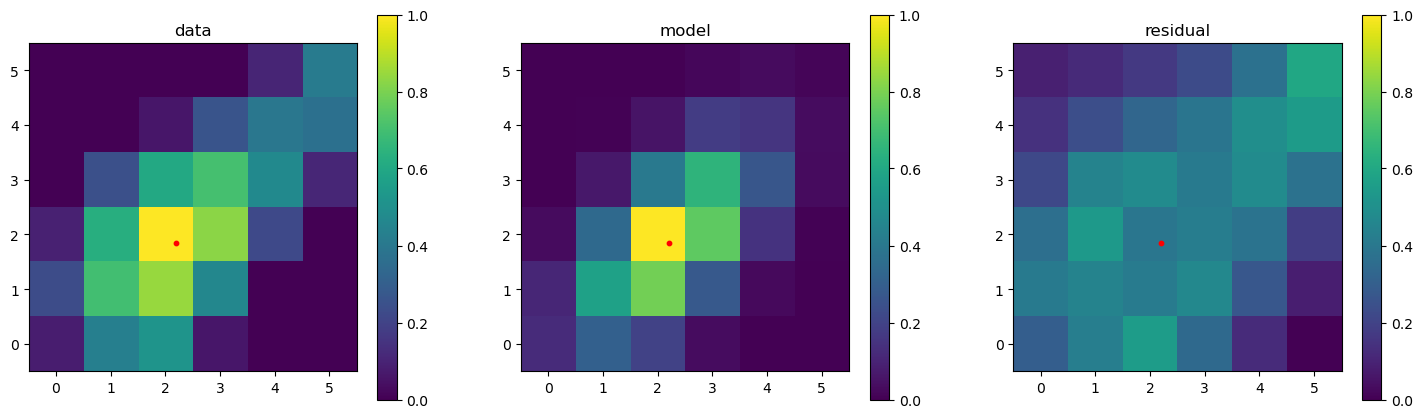

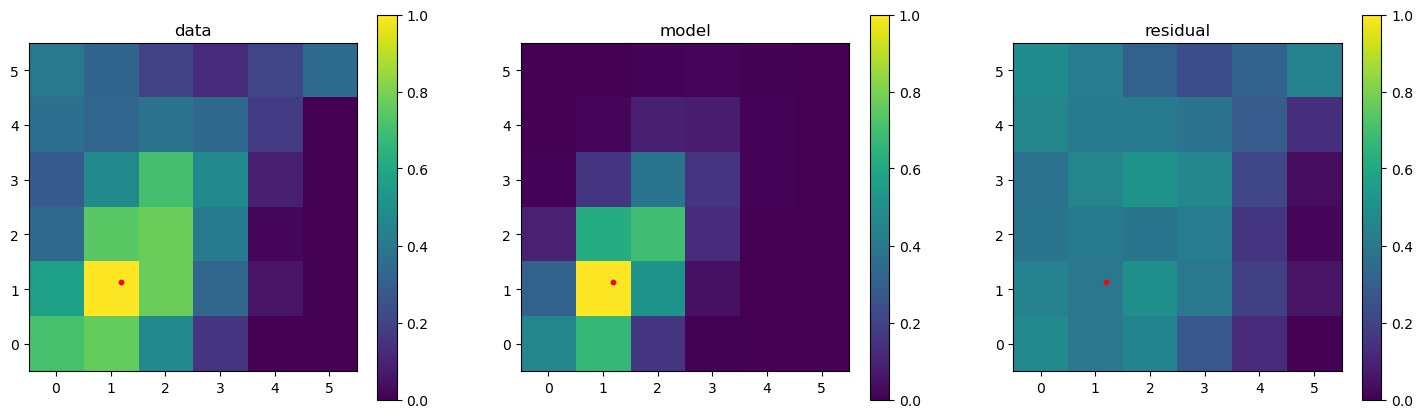

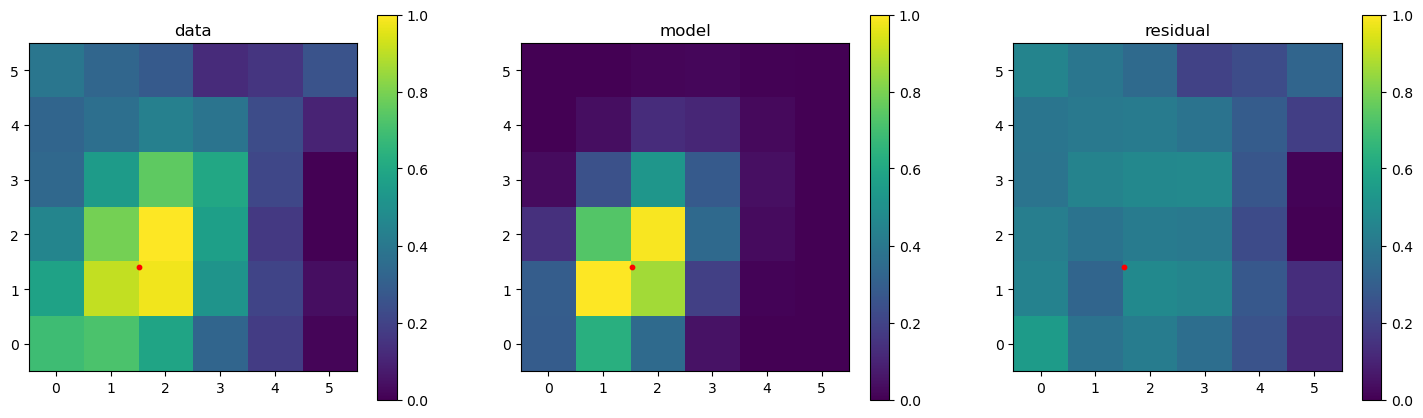

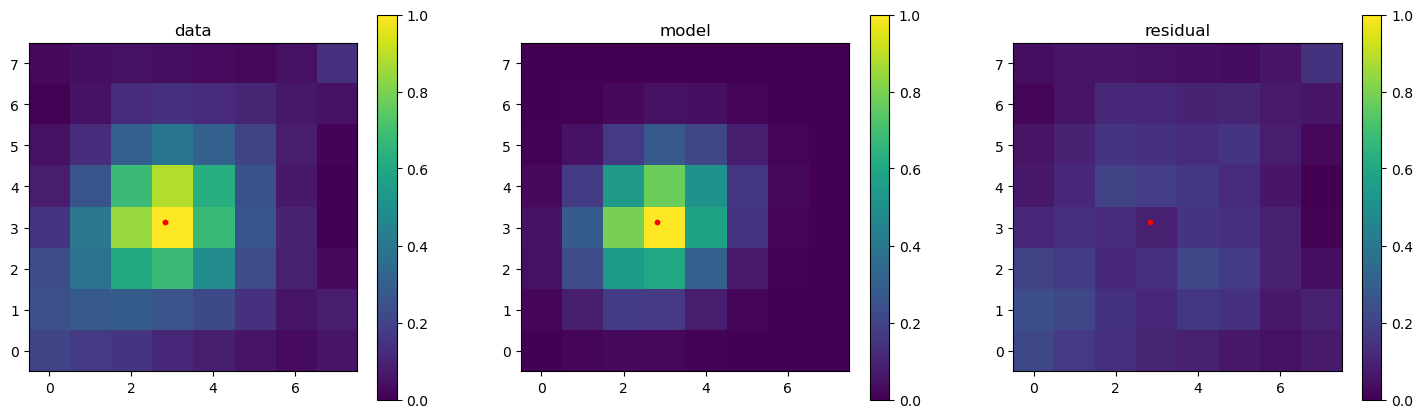

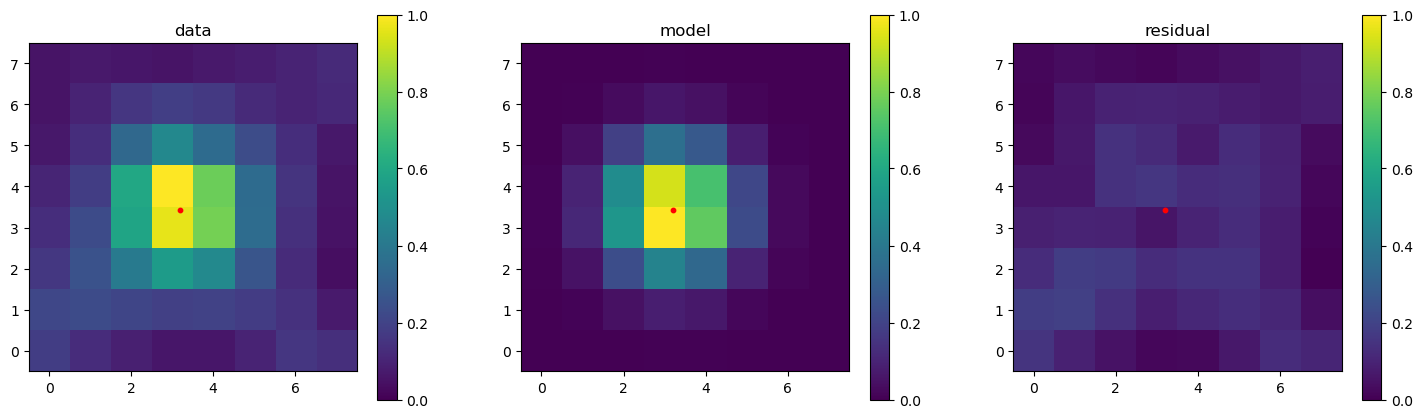

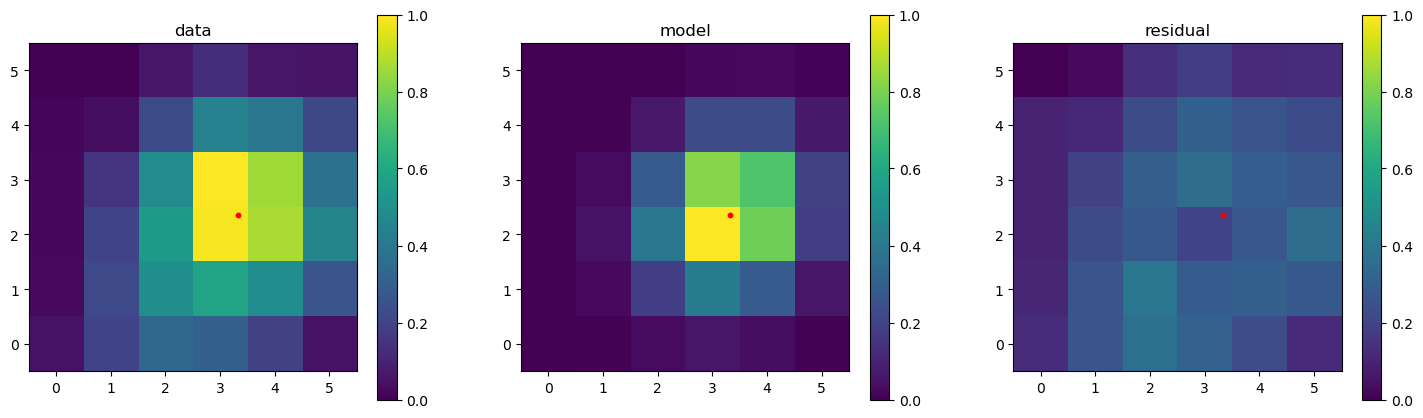

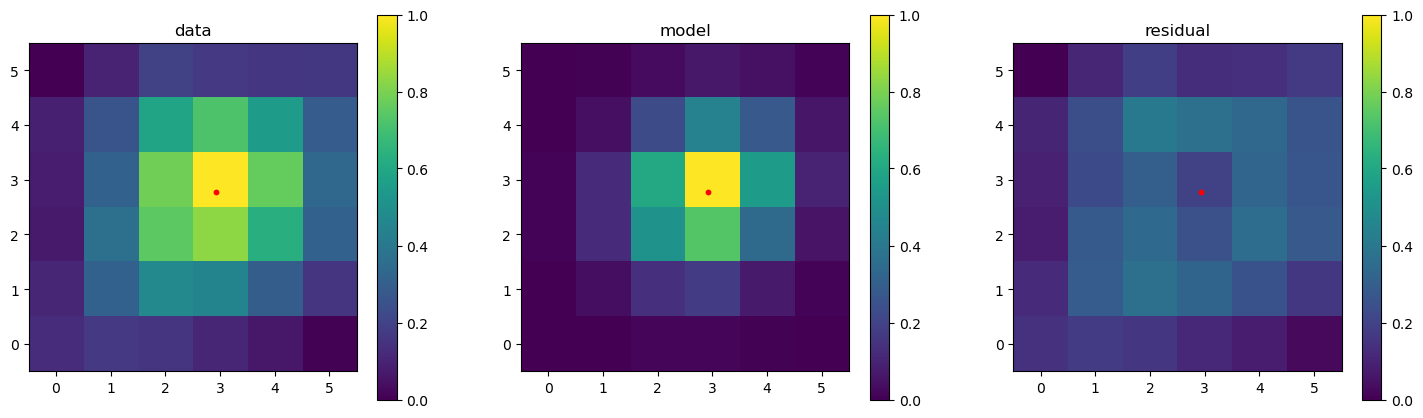

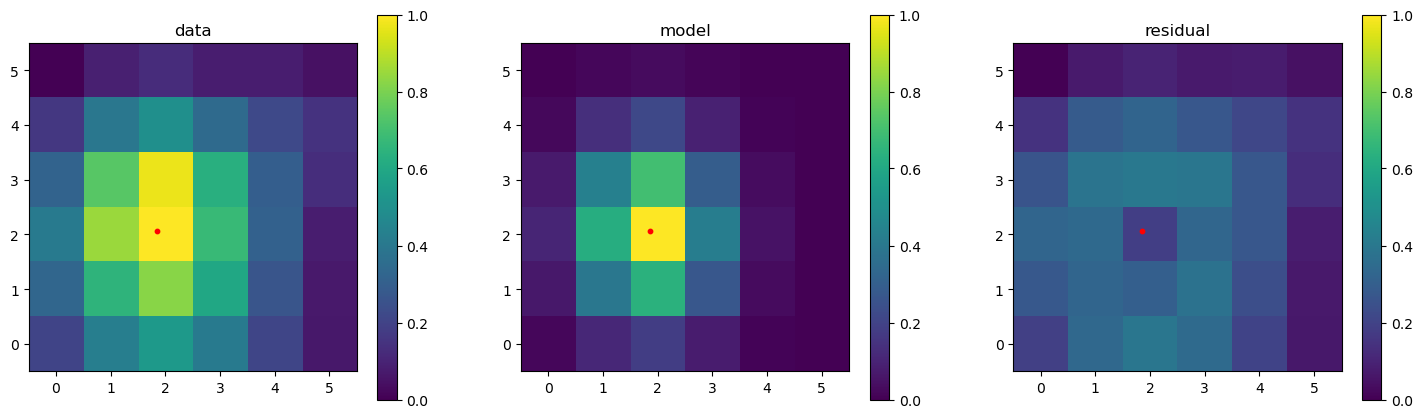

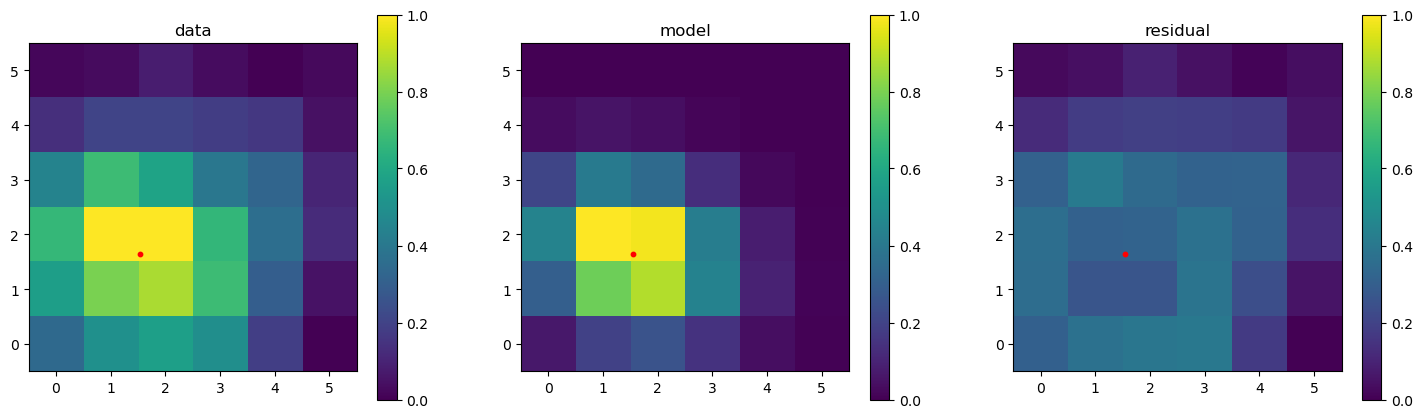

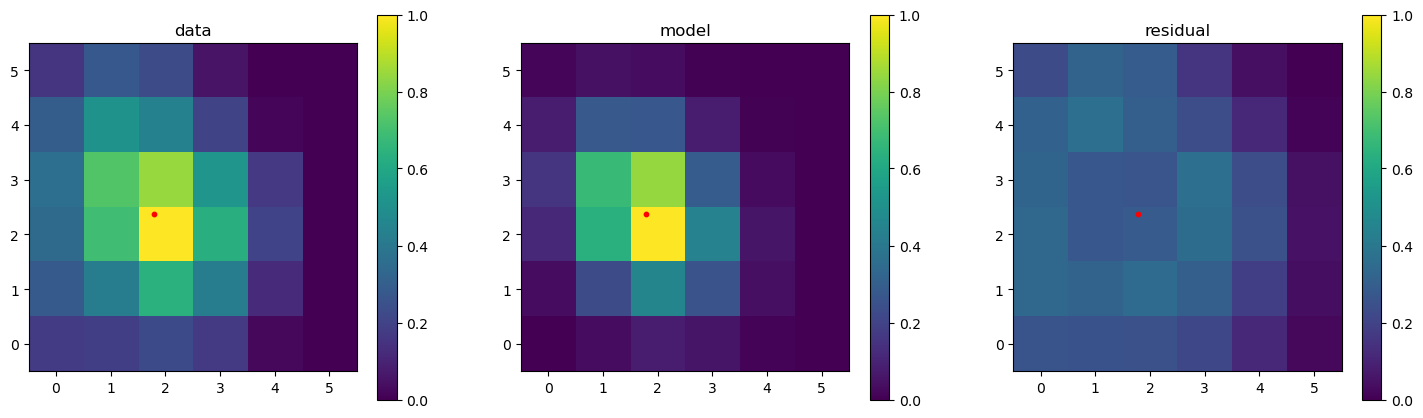

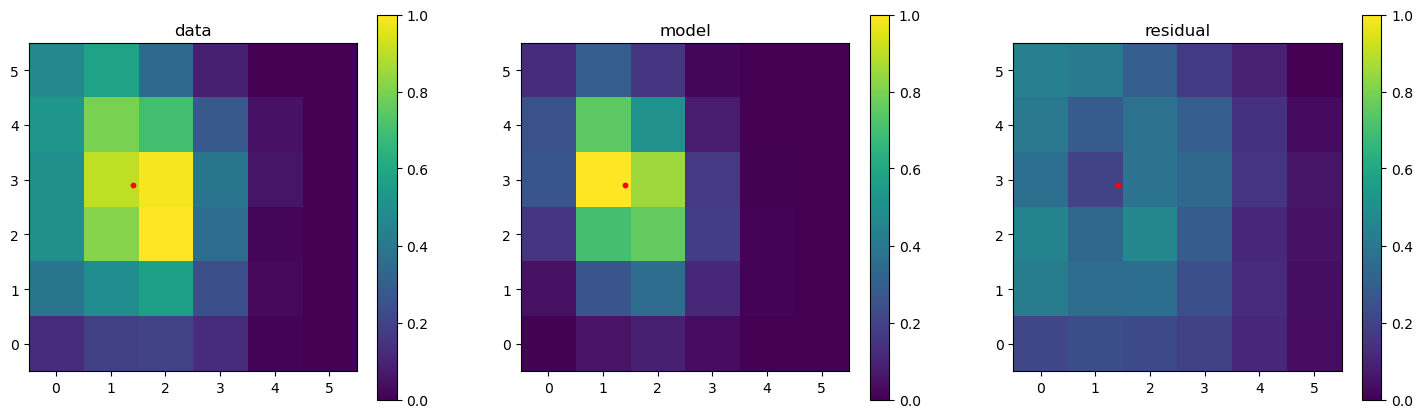

In [8]:
#matrices that store the intial values that are imputed
x_coord = [140, 141, 147, 148, 157, 158, 165, 166, 170, 172, 177, 178, 192, 194]
y_coord = [139, 141, 146, 147, 155, 156, 162, 163, 168, 169, 173, 174, 180, 181]
size = [3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3]
amp = [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
center_x = [1, 2, 2, 2, 1, 2, 3, 4, 3, 3, 2, 2, 2, 2]
center_y = [3, 3, 2, 2, 1, 2, 3, 5, 2, 3, 2, 2, 2, 2]
#helps the for loop pull the correct data
i = 0
#for loop repeats for each of the emission provided in the initial values
for k in range(int((len(x_coord)/2))):
    #calls the single gaussian function with the defined starting values 
    gaussian_1 = single_source_gaussian(cutout_1.data, x_coord[i], y_coord[i], size[i], amp[i], center_x[i], center_y[i]) 
    gaussian_2 = single_source_gaussian(cutout_2.data, x_coord[i+1], y_coord[i+1], size[i+1], amp[i+1], center_x[i+1], center_y[i+1])
    #converts the pixes values that the function returns into ra and dec
    emission_1 = utils.pixel_to_skycoord((gaussian_1.x_mean.value+(x_coord[i])-size[i]),(gaussian_1.y_mean.value+(y_coord[i])-size[i]), cutout_1.wcs, origin=0, mode='all', cls=None)
    emission_2 = utils.pixel_to_skycoord((gaussian_2.x_mean.value+(x_coord[i+1])-size[i+1]),(gaussian_2.y_mean.value+(y_coord[i+1])-size[i+1]), cutout_2.wcs, origin=0, mode='all', cls=None)
    #calculates the separation between the first and second emission
    separation = (emission_2.separation(emission_1))
    emission_separation.append(separation)
    #calculates the velocity of the knots baised on the ditance and the amount of time between the images
    #149597870.69 is the conversion from au to kilometeres and 31536000 is the amount of seconds in a year
    velo_gs1 = ((separation.arcsecond*distance_star*149597870.69)/(31536000*time_between_epochs))
    #converts the position of the knot and the angle into a Vx and Vy componet 
    angle = (emission_2.position_angle(emission_1).value-(np.pi/2))
    x_component = velo_gs1*np.cos(angle)
    y_component = velo_gs1*np.sin(angle)    
    #these append the x and y position of each of the emission to the matrices defined above
    x_coord_emission_1.append(gaussian_1.x_mean.value+(x_coord[i])-size[i])
    y_coord_emission_1.append(gaussian_1.y_mean.value+(y_coord[i])-size[i])
    x_coord_emission_2.append(gaussian_2.x_mean.value+(x_coord[i])-size[i])
    y_coord_emission_2.append(gaussian_2.y_mean.value+(y_coord[i])-size[i])
    if central_position_refrence:
        #calculates the separation between the star and the first epoch emission  
        position.append((emission_1.separation(center_star)).value*3600*414.3)
    else:
        print ()
    #appends the data
    velocity.append(velo_gs1)
    x_velocity.append(x_component)
    y_velocity.append(y_component)
    #this prints the velocity and angle of the emission  
    print ('Knot', k+1)
    print ('velocity (km s-1)', velo_gs1)
    print ('angle (radians)', angle)
    print ('x velocity (km s-1)', x_component)
    print ('y velocity (km s-1)', y_component) 
    #this increases the x value by two to change what inital value is pulled muving to the next emission
    i=i+2

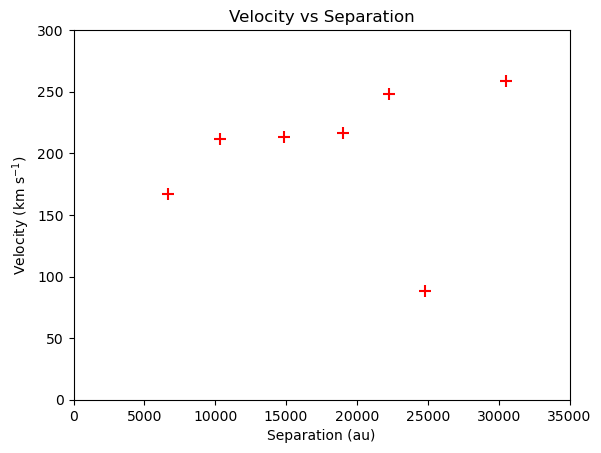

In [10]:
#creates a plot showing the relationship between velocity and separation
#creates the plot
fig, ax = plt.subplots()
#sets the size of the graph
ax.set_xlim([0, 35000])
ax.set_ylim([0, 300])
#plots the distance from the refrence star on the x axis and the velocity on the y axis
ax.scatter(position, velocity, marker='+', s=80, color='red')
#calls the axis lables and title
plt.rc('font', size=10)
ax.set_xlabel('Separation (au)')
ax.set_ylabel('Velocity (km s$^{-1}$)')
ax.set_title('Velocity vs Separation')
print ()